In [442]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import geopandas
from shapely.geometry import Point
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import r2_score

In [324]:
df_train.describe()

,incident_hour,zipcode,crime,population,population_density,housing_units,occupied_housing_units,median_home_value,median_household_income
count,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9.874000e+03,9874.000000
mean,11.925360,94116.662751,14.692627,32848.934981,23281.650800,15732.974276,14425.981365,7.724463e+05,75871.021369
std,6.786943,14.073532,18.234443,20236.401505,13331.307311,8928.712598,8257.802916,1.543596e+05,32335.456439
min,0.000000,94102.000000,1.000000,406.000000,5232.000000,368.000000,207.000000,4.704000e+05,22517.000000
25%,6.000000,94107.000000,2.000000,23088.000000,12926.000000,10769.000000,9717.000000,6.280000e+05,48750.000000
50%,12.000000,94114.000000,7.000000,31176.000000,20036.000000,15141.000000,13736.000000,7.682000e+05,81768.000000
75%,18.000000,94123.000000,20.000000,40798.000000,29596.000000,19255.000000,17939.000000,9.115000e+05,94479.000000
max,23.000000,94158.000000,140.000000,79407.000000,50983.000000,37182.000000,33342.000000,1.000001e+06,163949.000000


In [325]:
df_train = pd.read_csv("df_train.csv").dropna()
df_test = pd.read_csv("df_test.csv").dropna()

In [326]:
# Use one-hot encoding for categorical variable
X_train_raw = df_train.drop(columns = ['crime','police_district'])
X_test_raw = df_test.drop(columns = ['crime','police_district'])
X_train_dummy = pd.get_dummies(X_train_raw, 
                               columns = ['incident_day_of_week','incident_hour','zipcode'], 
                               drop_first = True)
X_test_dummy = pd.get_dummies(X_test_raw, 
                               columns = ['incident_day_of_week','incident_hour','zipcode'], 
                               drop_first = True)

In [327]:
# Standardize the numerical columns.
def standardize(df, cols, df_train):
    scalar = StandardScaler().fit(df_train[cols])
    result = df.copy()
    transformed_cols = scalar.transform(result[cols])
    result = result.drop(cols, 1)
    for i in range(len(cols)): 
        col = cols[i]
        result[col] = transformed_cols[:, i]
    return result
cols = ['population','population_density','housing_units',
        'occupied_housing_units','median_home_value','median_household_income']
X_train_clean = standardize(X_train_dummy,cols,X_train_dummy)
X_test_clean = standardize(X_test_dummy,cols,X_train_dummy)
X_train_clean.describe()

,incident_day_of_week_Monday,incident_day_of_week_Saturday,incident_day_of_week_Sunday,incident_day_of_week_Thursday,incident_day_of_week_Tuesday,incident_day_of_week_Wednesday,incident_hour_1,incident_hour_2,incident_hour_3,incident_hour_4,...,zipcode_94131.0,zipcode_94132.0,zipcode_94134.0,zipcode_94158.0,population,population_density,housing_units,occupied_housing_units,median_home_value,median_household_income
count,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,9874.000000,...,9874.000000,9874.000000,9874.000000,9874.000000,9.874000e+03,9.874000e+03,9.874000e+03,9.874000e+03,9.874000e+03,9.874000e+03
mean,0.143711,0.142192,0.138141,0.142293,0.143204,0.144318,0.035548,0.035143,0.033421,0.033016,...,0.046790,0.021065,0.038687,0.061981,1.539740e-16,-1.772039e-17,5.415064e-17,1.637112e-17,6.906568e-17,2.735136e-16
std,0.350814,0.349264,0.345065,0.349368,0.350299,0.351430,0.185169,0.184150,0.179743,0.178687,...,0.211198,0.143610,0.192859,0.241133,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.603278e+00,-1.353998e+00,-1.720937e+00,-1.721972e+00,-1.956870e+00,-1.650100e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-4.823698e-01,-7.768312e-01,-5.559845e-01,-5.702752e-01,-9.358253e-01,-8.387819e-01
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-8.267377e-02,-2.434731e-01,-6.630343e-02,-8.355931e-02,-2.751042e-02,1.823780e-01
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.928301e-01,4.736721e-01,3.944806e-01,4.254396e-01,9.008884e-01,5.754958e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.300825e+00,2.078022e+00,2.402375e+00,2.290800e+00,1.474261e+00,2.724020e+00


In [328]:
X_train_binary = X_train_dummy.copy()
X_train_binary = X_train_binary.drop(columns= cols)
X_test_binary = X_test_dummy.copy()
X_test_binary = X_test_binary.drop(columns= cols)

In [329]:
X_test_clean.describe()

,incident_day_of_week_Monday,incident_day_of_week_Saturday,incident_day_of_week_Sunday,incident_day_of_week_Thursday,incident_day_of_week_Tuesday,incident_day_of_week_Wednesday,incident_hour_1,incident_hour_2,incident_hour_3,incident_hour_4,...,zipcode_94131.0,zipcode_94132.0,zipcode_94134.0,zipcode_94158.0,population,population_density,housing_units,occupied_housing_units,median_home_value,median_household_income
count,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.00000,9854.000000,...,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000,9854.000000
mean,0.142785,0.140857,0.140045,0.142683,0.143597,0.142277,0.036939,0.035214,0.03491,0.032474,...,0.050233,0.020093,0.038259,0.061701,0.002508,0.002585,0.008927,0.008820,-0.002025,0.002931
std,0.349871,0.347891,0.347051,0.349767,0.350698,0.349352,0.188622,0.184330,0.18356,0.177265,...,0.218437,0.140327,0.191830,0.240624,0.989685,0.997469,0.994948,0.994554,0.995698,0.998357
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.603278,-1.353998,-1.720937,-1.721972,-1.956870,-1.650100
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.482370,-0.776831,-0.555984,-0.570275,-0.935825,-0.838782
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.082674,-0.243473,-0.066303,-0.083559,-0.027510,0.182378
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.392830,0.473672,0.394481,0.425440,0.900888,0.575496
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.300825,2.078022,2.402375,2.290800,1.474261,2.724020


In [330]:
# Get y_train and y_test
y_train = df_train.crime
y_test = df_test.crime

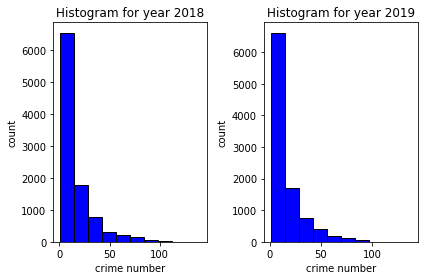

In [374]:
fig,ax = plt.subplots(1, 2)
# Draw the plot
ax[0].hist(y_train,
             color = 'blue', edgecolor = 'black')
# Title and labels
ax[0].set_title("Histogram for year 2018")
ax[0].set_xlabel('crime number')
ax[0].set_ylabel('count')
ax[1].hist(y_test,
             color = 'blue', edgecolor = 'black')
# Title and labels
ax[1].set_title('Histogram for year 2019')
ax[1].set_xlabel('crime number')
ax[1].set_ylabel('count')


plt.tight_layout()
plt.show()

## Base

In [331]:
df_train.sort_values(by = 'crime',ascending = False).head(20)

,incident_day_of_week,police_district,incident_hour,zipcode,crime,population,population_density,housing_units,occupied_housing_units,median_home_value,median_household_income
1446,Friday,Tenderloin,15,94103.0,140,27170.0,20036.0,14778.0,13098.0,628000.0,43364.0
4787,Sunday,Mission,0,94110.0,131,69333.0,29816.0,28913.0,27128.0,768200.0,82111.0
7782,Tuesday,Mission,18,94110.0,130,69333.0,29816.0,28913.0,27128.0,768200.0,82111.0
3355,Saturday,Mission,0,94110.0,128,69333.0,29816.0,28913.0,27128.0,768200.0,82111.0
10087,Wednesday,Tenderloin,15,94103.0,120,27170.0,20036.0,14778.0,13098.0,628000.0,43364.0
5387,Sunday,Southern,0,94103.0,119,27170.0,20036.0,14778.0,13098.0,628000.0,43364.0
8630,Tuesday,Tenderloin,15,94103.0,117,27170.0,20036.0,14778.0,13098.0,628000.0,43364.0
2012,Monday,Mission,16,94110.0,115,69333.0,29816.0,28913.0,27128.0,768200.0,82111.0
10076,Wednesday,Tenderloin,13,94103.0,113,27170.0,20036.0,14778.0,13098.0,628000.0,43364.0
1157,Friday,Southern,12,94103.0,113,27170.0,20036.0,14778.0,13098.0,628000.0,43364.0


We notice that most of crimes happend at places where zipcode are 94103 and 94110.

## Linear Regression

In [332]:
# Check colinearity
X_numerical = X_train_clean[cols]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]
vif["features"] = X_numerical.columns
vif.round(1)

,VIF Factor,features
0,21.5,population
1,2.8,population_density
2,1879.9,housing_units
3,2159.5,occupied_housing_units
4,2.0,median_home_value
5,1.7,median_household_income


In [333]:
# Dropout columns with huge VIF Factor
X_train_final = X_train_clean.drop(columns=['population','housing_units','occupied_housing_units'])
X_test_final = X_test_clean.drop(columns=['population','housing_units','occupied_housing_units'])

In [461]:
import statsmodels.api as sm
linear_regression = sm.OLS(y_train, X_train_binary)
results = linear_regression.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  crime   R-squared (uncentered):                   0.484
Model:                            OLS   Adj. R-squared (uncentered):              0.482
Method:                 Least Squares   F-statistic:                              180.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):                        0.00
Time:                        18:07:49   Log-Likelihood:                         -41878.
No. Observations:                9874   AIC:                                  8.386e+04
Df Residuals:                    9823   BIC:                                  8.422e+04
Df Model:                          51                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
incident_day_of_week_Monday        3.2567      0.603      5.404      0.000       2.075       4.438
incident_day_of_week_Saturday      3.6338      0.605      6.006      0.000       2.448       4.820
incident_day_of_week_Sunday        2.5023      0.609      4.111      0.000       1.309       3.695
incident_day_of_week_Thursday      3.1010      0.604      5.130      0.000       1.916       4.286
incident_day_of_week_Tuesday       2.9327      0.604      4.858      0.000       1.749       4.116
incident_day_of_week_Wednesday     3.3326      0.602      5.535      0.000       2.152       4.513
incident_hour_1                    6.3971      1.040      6.151      0.000       4.358       8.436
incident_hour_2                    4.8144      1.047      4.600      0.000       2.763       6.866
incident_hour_3                    2.9841      1.062      2.809      0.005       0.902       5.066
incident_hour_4                    1.1303      1.070      1.057      0.291      -0.967       3.227
incident_hour_5                    1.2663      1.077      1.176      0.240      -0.844       3.377
incident_hour_6                    2.5203      1.046      2.410      0.016       0.470       4.570
incident_hour_7                    5.3754      1.013      5.305      0.000       3.389       7.362
incident_hour_8                    8.1329      0.976      8.332      0.000       6.220      10.046
incident_hour_9                    8.7964      0.952      9.241      0.000       6.931      10.662
incident_hour_10                  10.7496      0.962     11.177      0.000       8.864      12.635
incident_hour_11                  11.8550      0.956     12.398      0.000       9.981      13.729
incident_hour_12                  15.4709      0.940     16.464      0.000      13.629      17.313
incident_hour_13                  12.6655      0.957     13.239      0.000      10.790      14.541
incident_hour_14                  12.3186      0.951     12.955      0.000      10.455      14.183
incident_hour_15                  13.7875      0.957     14.413      0.000      11.912      15.663
incident_hour_16                  14.2092      0.953     14.907      0.000      12.341      16.078
incident_hour_17                  15.1601      0.950     15.955      0.000      13.298      17.023
incident_hour_18                  16.2408      0.955     17.012      0.000      14.369      18.112
incident_hour_19                  15.4955      0.965     16.058      0.000      13.604      17.387
incident_hour_20                  13.4269      0.962     13.956      0.000      11.541      15.313
incident_hour_21                  11.2875      0.964     11.707      0.000       9.398      13.178
incident_hour_

In [452]:
OS =LinearRegression()
OS.fit(X_train_final,y_train)
y_pred_lr = OS.predict(X_test_final)
MSE_lr =mse(y_pred_lr,y_test)
print("R square for NN method is:",r2_score(y_pred_lr,y_test))
print("MSE error for linear regression method is:",MSE_lr)

R square for NN method is: -2.863269081181666
MSE error for linear regression method is: 242.18510968129993


Text(0, 0.5, 'Number of Crime')

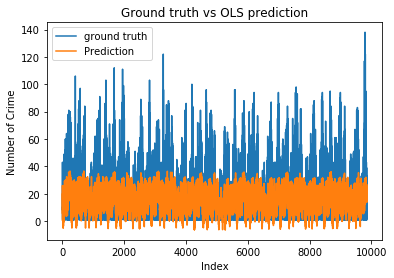

In [451]:
plt.plot(np.arange(len(y_test)),y_test,label = "ground truth")
plt.plot(np.arange(len(y_test)),y_pred_lr,label = "Prediction")
plt.legend()
plt.title("Ground truth vs OLS prediction")
plt.xlabel("Index")
plt.ylabel("Number of Crime")

## Regularization


### LASSO Regression

In [354]:
lam = [0.0001,0.01,0.1,0.5,1,5,10,50,100]
# Fit the LASSO model
model_lasso = LassoCV(alphas = lam, max_iter = 100000,fit_intercept = True, cv = 5)
model_lasso.fit(X_train_final,y_train)
print("The best alpha for lasso is %s" %model_lasso.alpha_)
y_pred_lasso = model_lasso.predict(X_test_final)
MSE_lasso =mse(y_pred_lasso,y_test)
print("MSE error for LASSO regression method is:",MSE_lasso)
print("R square for NN method is:",r2_score(y_pred_lasso,y_test))

The best alpha for lasso is 0.01
MSE error for LASSO regression method is: 241.88350530051574
R square for NN method is: -3.1011809570681095


Text(0, 0.5, 'Number of Crime')

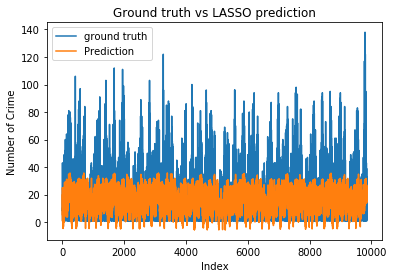

In [338]:
plt.plot(np.arange(len(y_test)),y_test,label = "ground truth")
plt.plot(np.arange(len(y_test)),y_pred_lasso,label = "Prediction")
plt.legend()
plt.title("Ground truth vs LASSO prediction")
plt.xlabel("Index")
plt.ylabel("Number of Crime")

### Ridge Regression

In [353]:
# Fit the Ridge model
model_ridge = RidgeCV(alphas = lam,fit_intercept = True,cv = 5)
model_ridge.fit(X_train_final,y_train)
print("The best alpha for ridge is %s" %model_ridge.alpha_)
print("R square for NN method is:",r2_score(y_pred_ridge,y_test))
y_pred_ridge = model_ridge.predict(X_test_final)
MSE_ridge =mse(y_pred_ridge,y_test)
print("MSE error for Ridge regression method is:",MSE_ridge)

The best alpha for ridge is 5.0
R square for NN method is: -2.947736957987154
MSE error for Ridge regression method is: 242.041617104608


Text(0, 0.5, 'Number of Crime')

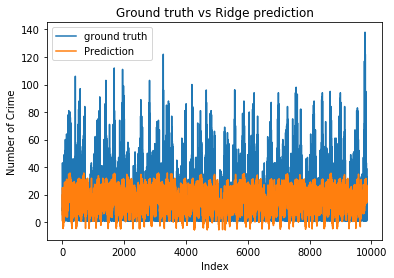

In [340]:
plt.plot(np.arange(len(y_test)),y_test,label = "ground truth")
plt.plot(np.arange(len(y_test)),y_pred_lasso,label = "Prediction")
plt.legend()
plt.title("Ground truth vs Ridge prediction")
plt.xlabel("Index")
plt.ylabel("Number of Crime")

## Random Forest

MSE error for Random Forest method is: 258.1126469997404
R square for NN method is: -1.5528202409525553


Text(0, 0.5, 'Number of Crime')

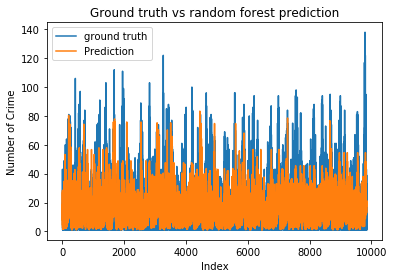

In [455]:
rf = RandomForestRegressor()
rf.fit(X_train_final,y_train)
y_pred_rf = rf.predict(X_test_final)
MSE_rf =mse(y_pred_rf,y_test)
print("MSE error for Random Forest method is:",MSE_rf)
print("R square for NN method is:",r2_score(y_pred_rf,y_test))
plt.plot(np.arange(len(y_test)),y_test,label = "ground truth")
plt.plot(np.arange(len(y_test)),y_pred_rf,label = "Prediction")
plt.legend()
plt.title("Ground truth vs random forest prediction")
plt.xlabel("Index")
plt.ylabel("Number of Crime")

In [342]:
list(zip(X_train_final.columns, rf.feature_importances_))

[('incident_day_of_week_Monday', 0.044017908133182106),
 ('incident_day_of_week_Saturday', 0.04441163744433469),
 ('incident_day_of_week_Sunday', 0.04426482967654845),
 ('incident_day_of_week_Thursday', 0.045547338166554395),
 ('incident_day_of_week_Tuesday', 0.049060745393161125),
 ('incident_day_of_week_Wednesday', 0.05018517370065335),
 ('incident_hour_1', 0.011474533346639402),
 ('incident_hour_2', 0.011812391931200138),
 ('incident_hour_3', 0.014944061322339134),
 ('incident_hour_4', 0.019656945758813205),
 ('incident_hour_5', 0.018854826224442647),
 ('incident_hour_6', 0.01524712743651698),
 ('incident_hour_7', 0.011697690750428579),
 ('incident_hour_8', 0.010579180414368497),
 ('incident_hour_9', 0.011292409945708404),
 ('incident_hour_10', 0.01451051780437341),
 ('incident_hour_11', 0.015627447751642307),
 ('incident_hour_12', 0.02452451558550035),
 ('incident_hour_13', 0.018035964129087773),
 ('incident_hour_14', 0.018250949263427043),
 ('incident_hour_15', 0.01939754303107859

## SVM

MSE error for SVM method is: 294.96319017222913
R square for NN method is: -17.707635162317825


Text(0, 0.5, 'Number of Crime')

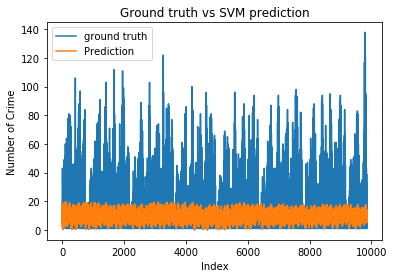

In [351]:
### SVM
svm = SVR()
svm.fit(X_train_final,y_train)
y_pred_svm = svm.predict(X_test_final)
MSE_svm =mse(y_pred_svm,y_test)
print("MSE error for SVM method is:",MSE_svm)
print("R square for NN method is:",r2_score(y_pred_svm,y_test))
plt.plot(np.arange(len(y_test)),y_test,label = "ground truth")
plt.plot(np.arange(len(y_test)),y_pred_svm,label = "Prediction")
plt.legend()
plt.title("Ground truth vs SVM prediction")
plt.xlabel("Index")
plt.ylabel("Number of Crime")

## KNN

R square for NN method is: -2.1807872192714606
MSE error for KNN method is: 264.4894986807388


Text(0, 0.5, 'Number of Crime')

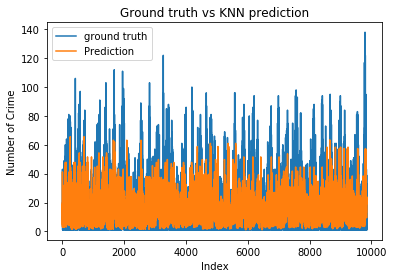

In [350]:
KNN = KNeighborsRegressor()
KNN.fit(X_train_final,y_train)
y_pred_KNN = KNN.predict(X_test_final)
MSE_KNN =mse(y_pred_KNN,y_test)
print("R square for NN method is:",r2_score(y_pred_KNN,y_test))
print("MSE error for KNN method is:",MSE_KNN)
plt.plot(np.arange(len(y_test)),y_test,label = "ground truth")
plt.plot(np.arange(len(y_test)),y_pred_KNN,label = "Prediction")
plt.legend()
plt.title("Ground truth vs KNN prediction")
plt.xlabel("Index")
plt.ylabel("Number of Crime")

## Neural Network

In [434]:
from tensorflow.keras import layers
validation_split = 0.2
epochs = 50
optimizer = tf.keras.optimizers.RMSprop(0.0005)
model = tf.keras.models.Sequential()
model.add(layers.Dense(units=100, activation='relu',input_dim = 54))
model.add(layers.Dense(units=100, activation='relu'))
model.add(layers.Dense(units=100, activation='relu'))
model.add(layers.Dense(units=100, activation='relu'))
model.add(layers.Dense(units=1, activation='relu'))
model.compile(loss = 'mse', optimizer = optimizer)
model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_138 (Dense)            (None, 100)               5500      
_________________________________________________________________
dense_139 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_140 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_141 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_142 (Dense)            (None, 1)                 101       
Total params: 35,901
Trainable params: 35,901
Non-trainable params: 0
_________________________________________________________________


In [435]:
#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train_final, y_train, batch_size=64, epochs=epochs, 
                    validation_split=validation_split, verbose=1)
                   #callbacks=[early_stop])

Train on 7899 samples, validate on 1975 samples
Epoch 1/50
7899/7899 [==============================] - 1s 80us/sample - loss: 351.8171 - val_loss: 324.3093
Epoch 2/50
7899/7899 [==============================] - 0s 26us/sample - loss: 290.2456 - val_loss: 302.7286
Epoch 3/50
7899/7899 [==============================] - 0s 24us/sample - loss: 275.1282 - val_loss: 299.8840
Epoch 4/50
7899/7899 [==============================] - 0s 25us/sample - loss: 269.9069 - val_loss: 290.8229
Epoch 5/50
7899/7899 [==============================] - 0s 24us/sample - loss: 267.1550 - val_loss: 291.3475
Epoch 6/50
7899/7899 [==============================] - 0s 25us/sample - loss: 265.9421 - val_loss: 297.0736
Epoch 7/50
7899/7899 [==============================] - 0s 25us/sample - loss: 264.8605 - val_loss: 299.5682
Epoch 8/50
7899/7899 [==============================] - 0s 25us/sample - loss: 263.5503 - val_loss: 309.0956
Epoch 9/50
7899/7899 [==============================] - 0s 25us/sample - loss: 2

Text(0, 0.5, 'Number of Crime')

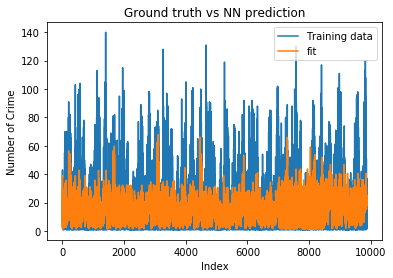

In [432]:
plt.plot(np.arange(len(y_train)),y_train,label = "Training data")
plt.plot(np.arange(len(y_train)),model.predict(X_train_final),label = "fit")
plt.legend()
plt.title("Ground truth vs NN prediction")
plt.xlabel("Index")
plt.ylabel("Number of Crime")

MSE error for NN method is: 254.38533564540523
R square for NN method is: -1.9748697182253934


Text(0, 0.5, 'Number of Crime')

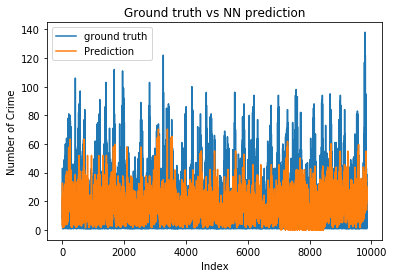

In [436]:
y_pred_NN = model.predict(X_test_final)
MSE_NN =mse(y_pred_NN,y_test)
print("MSE error for NN method is:",MSE_NN)
print("R square for NN method is:",r2_score(y_pred_NN,y_test))
plt.plot(np.arange(len(y_test)),y_test,label = "ground truth")
plt.plot(np.arange(len(y_test)),y_pred_NN,label = "Prediction")
plt.legend()
plt.title("Ground truth vs NN prediction")
plt.xlabel("Index")
plt.ylabel("Number of Crime")

In [437]:
print("R square for baseline method is:",r2_score([np.mean(y_test) for i in y_test],y_test))
print("R square for baseline method is:",mse([np.mean(y_test) for i in y_test],y_test))

R square for baseline method is: 0.0
R square for baseline method is: 292.5302685804999


In [389]:
X_train_final.isna()

,incident_day_of_week_Monday,incident_day_of_week_Saturday,incident_day_of_week_Sunday,incident_day_of_week_Thursday,incident_day_of_week_Tuesday,incident_day_of_week_Wednesday,incident_hour_1,incident_hour_2,incident_hour_3,incident_hour_4,...,zipcode_94123.0,zipcode_94124.0,zipcode_94127.0,zipcode_94131.0,zipcode_94132.0,zipcode_94134.0,zipcode_94158.0,population_density,median_home_value,median_household_income
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10129,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10130,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10131,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10132,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
